**Introduction**

The aim of this exercise is to code an execution algorithmic strategy that tries to achieve an execution cost close to the VWAP market benchmark (Volume Weighted Average Price). It follows the optimal execution strategy to track VWAP discussed in Busseti & Boyd (2015), see the notes of the course for details.

Delivery: Jupyter notebook (Python) with all the compulsory parts of the exercise and results

**Data reading and preparation**

Import the csv file “volume_price_2014_18.csv” required for the exercise. It contains four columns: date, time, volume and price. Load it into a Pandas dataframe. The data corresponds to market volumes and volume weighted average prices for intervals of one minute from 2014 to 2018. Perform an exploratory analysis in order to detect potential issues (hint: days with zero volume). Discard any anomaly you think it can affect the quality of the analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_df = pd.read_csv("volume_price_2014_18.csv")

In [3]:
filtered_df = data_df[data_df['volume'] > 0]

print(filtered_df['volume'].sum(),data_df['volume'].sum())

1213697033 1213697033


Resample the data to intervals of five minutes that will make volume prediction an easier task. For each five minutes interval, the volume is the sum of volumes for each one minute interval, and the price is the volume weighted average price of one minute intervals. [Check: the total volume per day after resampling cannot change with respect to original one minute intervals]. The result should be a dataset with a row per day and a column per 5 minute interval (bin). For simplicity to work with the backtesting, generate columns time (e.g. 9:00:00), date (2014-01-02), volume, vwap

In [5]:
# Asegúrate de que 'filtered_df' no tenga volumen 0
filtered_df = data_df[data_df['volume'] > 0].copy()

# Crear la columna vol_price para el VWAP
filtered_df['vol_price'] = filtered_df['volume'] * filtered_df['price']

# Nos aseguramos que 'time' tiene formato timedelta
filtered_df['time'] = pd.to_timedelta(filtered_df['time'])
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

# Crear una nueva columna 'time_5min' para redondear a intervalos de 5 minutos
filtered_df['time_5min'] = filtered_df['time'].dt.floor('5min')

# Agrupar por 'date' y 'time_5min' para sumar el volumen y vol_price
resampled_df = filtered_df.groupby(['date', 'time_5min']).agg({
    'volume': 'sum',
    'vol_price': 'sum'
}).reset_index()

# Calcular el VWAP
resampled_df['vwap'] = resampled_df['vol_price'] / resampled_df['volume']

# Eliminar filas con volumen igual a 0 después del resampleo
resampled_df = resampled_df[resampled_df['volume'] > 0]

# Eliminar la columna vol_price ya que ahora usamos vwap
resampled_df = resampled_df.drop(columns=['vol_price'])

# Mostrar las primeras filas
print(resampled_df.head())

# Comprobar el número de filas con volumen igual a 0
volume_zero_rows = resampled_df[resampled_df['volume'] == 0]
print(f"Número de filas con volumen igual a 0 después del resampleo: {len(volume_zero_rows)}")

print(f"La suma de volumen total de resampled_df es: {resampled_df['volume'].sum()} y la de filtered_df es: {filtered_df['volume'].sum()}")

        date       time_5min  volume        vwap
0 2014-01-02 0 days 09:00:00   24732  131.060911
1 2014-01-02 0 days 09:05:00   22744  131.239107
2 2014-01-02 0 days 09:10:00   23342  131.215468
3 2014-01-02 0 days 09:15:00   24077  131.217174
4 2014-01-02 0 days 09:20:00   24417  131.046016
Número de filas con volumen igual a 0 después del resampleo: 0
La suma de volumen total de resampled_df es: 1213697033 y la de filtered_df es: 1213697033


Divide the dataset in two parts: training and test. Take the first three years for training and the last year for test. Do not use the test set in any training stage!! It will be used exclusively to assess the performance of your model and execution algorithm.

In [9]:
# Establecemos la fecha límite para dividir en conjunto de entrenamiento y prueba
train_end_date = pd.Timestamp('2017-01-02')

# Dividimos el dataframe en entrenamiento y testeo, asegurándonos de comparar correctamente
train_df = resampled_df[resampled_df['date'] < train_end_date].copy()
test_df = resampled_df[resampled_df['date'] >= train_end_date].copy()

# Mostramos el número de filas en cada conjunto
print(f"El dataset de entrenamiento tiene: {len(train_df)} filas y el de testeo tiene: {len(test_df)} filas")
print("Primera fila de train_df:")
print(train_df.head(1))
print("\nPrimera fila de test_df:")
print(test_df.head(1))

El dataset de entrenamiento tiene: 75210 filas y el de testeo tiene: 31612 filas
Primera fila de train_df:
        date       time_5min  volume        vwap
0 2014-01-02 0 days 09:00:00   24732  131.060911

Primera fila de test_df:
            date       time_5min  volume        vwap
75210 2017-01-02 0 days 09:00:00   12139  156.039768


For each day in the training set, calculate the total market volume of the day, and plot the histogram

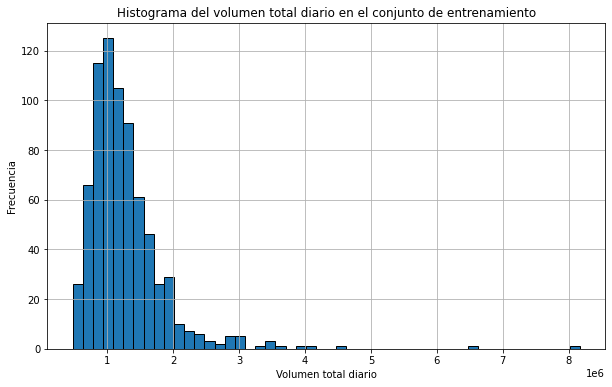

In [10]:
# Calcular el volumen total de mercado por cada día en el conjunto de entrenamiento
daily_volume_train = train_df.groupby('date')['volume'].sum()

# Graficar el histograma del volumen total diario
plt.figure(figsize=(10, 6))
plt.hist(daily_volume_train, bins=50, edgecolor='black')
plt.title('Histograma del volumen total diario en el conjunto de entrenamiento')
plt.xlabel('Volumen total diario')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Calculate the average daily volume (ADV) as a mean and also as a median over daily volumes. How much do they differ? What are the advantages and disadvantages of using median vs mean to get an “average” estimation

In [15]:
# Calcular el volumen total de mercado por cada día en el conjunto de entrenamiento
daily_volume_train = train_df.groupby('date')['volume'].sum()

# Calcular el Volumen Medio Diario (ADV) como media y mediana
adv_mean = daily_volume_train.mean()  # Media
adv_median = daily_volume_train.median()  # Mediana

# Mostrar resultados
print(f"Volumen Medio Diario (VAD) como media: {adv_mean}")
print(f"Volumen Medio Diario (VAD) como mediana: {adv_median}")
print(f"La diferencia entre la media y la mediana es: {adv_mean - adv_median}")

Volumen Medio Diario (VAD) como media: 1261181.7411924119
Volumen Medio Diario (VAD) como mediana: 1136875.0
La diferencia entre la media y la mediana es: 124306.74119241186


La media es útil cuando los datos están distribuidos de manera simétrica y no contienen muchos valores atípicos, pero puede ser engañosa si hay días con volúmenes muy extremos.
La mediana es una opción más robusta para estimar el volumen "típico" en casos donde la distribución es asimétrica o contiene valores extremos. Es menos susceptible a ser influenciada por outliers.

Separate the train set in days of the week (Mondays, Tuesdays… Fridays) and redo the analysis for each day of the week. Do you see any meaningful difference between these results and the global results? Do you see any pattern across days of the week?

In [18]:
# Añadir una columna 'weekday' para identificar el día de la semana (0=Lunes, 6=Domingo)
train_df['weekday'] = pd.to_datetime(train_df['date']).dt.weekday

# Diccionario para mapear los números de los días de la semana a sus nombres
weekday_map = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes'}

# Inicializar el diccionario para almacenar los resultados
weekday_vad_stats = {}

# Calcular el VAD (media y mediana) para cada día de la semana
for weekday, weekday_name in weekday_map.items():
    # Filtrar el DataFrame para obtener solo los datos del día de la semana específico
    daily_volume_train = train_df[train_df['weekday'] == weekday].groupby('date')['volume'].sum()

    # Calcular la media y la mediana
    vad_mean = daily_volume_train.mean()
    vad_median = daily_volume_train.median()

    # Guardar los resultados en el diccionario
    weekday_vad_stats[weekday_name] = {'mean': vad_mean, 'median': vad_median}

# Mostrar los resultados para cada día de la semana
for day, stats in weekday_vad_stats.items():
    print(f"{day}:")
    print(f"  Volumen Medio Diario (VAD) - Media: {stats['mean']}")
    print(f"  Volumen Medio Diario (VAD) - Mediana: {stats['median']}\n")


Lunes:
  Volumen Medio Diario (VAD) - Media: 1165484.2785714285
  Volumen Medio Diario (VAD) - Mediana: 1043696.0

Martes:
  Volumen Medio Diario (VAD) - Media: 1197613.6168831168
  Volumen Medio Diario (VAD) - Mediana: 1116151.0

Miércoles:
  Volumen Medio Diario (VAD) - Media: 1174438.8157894737
  Volumen Medio Diario (VAD) - Mediana: 1089270.5

Jueves:
  Volumen Medio Diario (VAD) - Media: 1339089.1088435375
  Volumen Medio Diario (VAD) - Mediana: 1194949.0

Viernes:
  Volumen Medio Diario (VAD) - Media: 1433041.5862068965
  Volumen Medio Diario (VAD) - Mediana: 1268933.0



[Optional] Can you think about other kind of special days where a specific volume curve should be constructed? Which kind of volume profiles have these days?

In [ ]:
# Días de anuncions de política monetarias y económicas
# Días de publicación de datos económicos clave (empleo, inflación, PIB)
# Vencimiento de contratos de futuros y opciones (conocido como "quadruple witching")
# Días de rebalanceo de índices (como el S&P 500)
# Días previos y posteriores a festivos

**Static volume prediction**

For each day (don’t differentiate here between days of the week) calculate the median of volumes for each interval of five minutes using the data from the same interval across days of the training set. You have to get a single median volume curve with as many points as five minute intervals in a day.

        time_5min   volume
0 0 days 09:00:00  15851.5
1 0 days 09:05:00  18691.5
2 0 days 09:10:00  15503.5


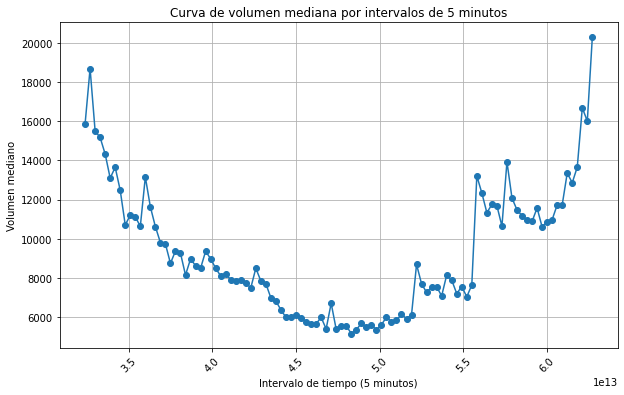

In [19]:
# Agrupar por el intervalo de 5 minutos (es decir, por la columna 'time') y calcular la mediana del volumen para cada intervalo
median_volume_by_time = train_df.groupby('time_5min')['volume'].median()

# Crear un DataFrame con la curva de la mediana de volumen por intervalos de 5 minutos
median_volume_curve = median_volume_by_time.reset_index()

# Mostrar la curva mediana de volumen
print(median_volume_curve.head(3))

# Graficar la curva de volumen mediana

plt.figure(figsize=(10, 6))
plt.plot(median_volume_curve['time_5min'], median_volume_curve['volume'], marker='o')
plt.title('Curva de volumen mediana por intervalos de 5 minutos')
plt.xlabel('Intervalo de tiempo (5 minutos)')
plt.ylabel('Volumen mediano')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Get the total volume of this curve, and generate a normalized volume curve by dividing each median volume per interval by the total volume. The resulting normalized curve has to sum to 1. This is a baseline static volume predictor. Plot the static curve. You should see the characteristic "U" shape of market volumes intraday, where most of the the trading happens at the beginning and the end of the trading session. Or more accurately, a "J" shape, with more trading activity at the end of the trading session.

Volumen total normalizado: 1.0


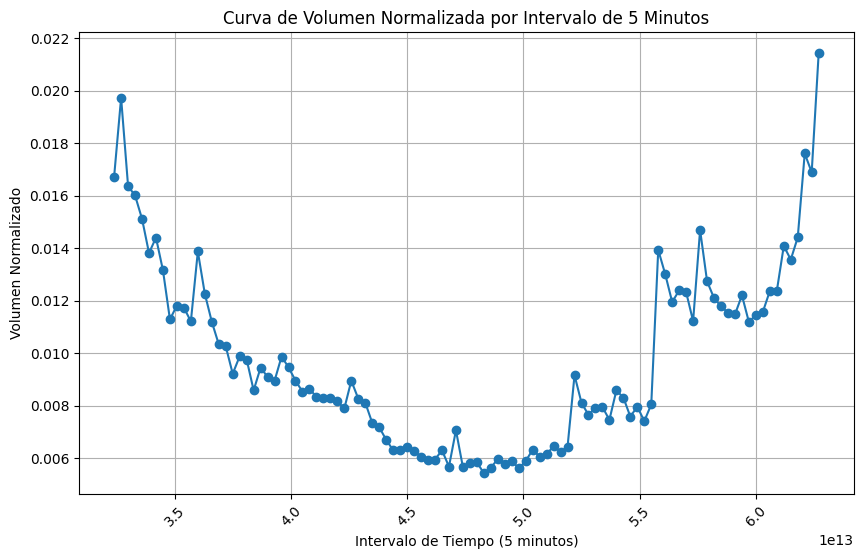

In [32]:
# Calcular el volumen total de la curva de volumen mediana
total_volume = median_volume_curve['volume'].sum()

# Normalizar la curva de volumen dividiendo cada volumen por el volumen total
median_volume_curve['normalized_volume'] = median_volume_curve['volume'] / total_volume

# Verificar que la curva normalizada suma 1
print(f"Volumen total normalizado: {median_volume_curve['normalized_volume'].sum()}")

# Graficar la curva de volumen normalizada
plt.figure(figsize=(10, 6))
plt.plot(median_volume_curve['time_5min'], median_volume_curve['normalized_volume'], marker='o')
plt.title('Curva de Volumen Normalizada por Intervalo de 5 Minutos')
plt.xlabel('Intervalo de Tiempo (5 minutos)')
plt.ylabel('Volumen Normalizado')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Repeat the same analysis but discriminating across days of the week so you get five different static volume curves, one per day of the week. You can also optionally consider other special days where you have detected particular volume profiles. Plot the static curves for each day of the week (and special days).

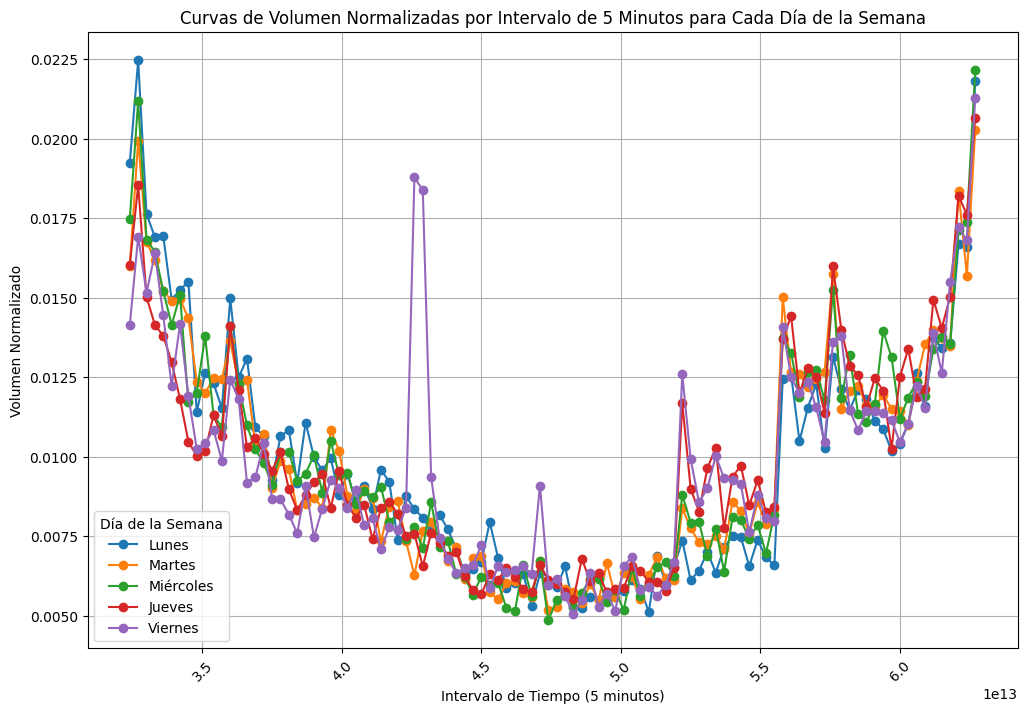

In [36]:
# Diccionario para mapear los números de los días de la semana a sus nombres
weekday_map = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes'}

# Crear un contenedor para almacenar las curvas de volumen normalizadas por día de la semana
weekday_volume_curves = {}

# Iterar sobre los días de la semana (de 0=Lunes a 4=Viernes)
for weekday, weekday_name in weekday_map.items():
    # Filtrar los datos para el día de la semana específico
    weekday_data = train_df[train_df['weekday'] == weekday]
    
    # Agrupar por intervalo de 5 minutos ('time') y calcular la mediana del volumen para cada intervalo
    median_volume_by_time = weekday_data.groupby('time_5min')['volume'].median()
    
    # Crear la curva de volumen mediana para ese día de la semana
    median_volume_curve = median_volume_by_time.reset_index()
    
    # Calcular el volumen total para ese día de la semana
    total_volume = median_volume_curve['volume'].sum()
    
    # Normalizar la curva de volumen
    median_volume_curve['normalized_volume'] = median_volume_curve['volume'] / total_volume
    
    # Guardar la curva normalizada en el diccionario
    weekday_volume_curves[weekday_name] = median_volume_curve

# Graficar las curvas de volumen normalizadas para cada día de la semana
plt.figure(figsize=(12, 8))
for weekday_name, curve in weekday_volume_curves.items():
    plt.plot(curve['time_5min'], curve['normalized_volume'], marker='o', label=weekday_name)

plt.title('Curvas de Volumen Normalizadas por Intervalo de 5 Minutos para Cada Día de la Semana')
plt.xlabel('Intervalo de Tiempo (5 minutos)')
plt.ylabel('Volumen Normalizado')
plt.xticks(rotation=45)
plt.legend(title="Día de la Semana")
plt.grid(True)
plt.show()

Evaluate the quality of this baseline static volume predictor in the test set. For that, you need to normalize to one each of the daily volume profiles of the test set, and then compare the prediction for each 5 minute interval with the actual value. Use RMSE as the quality metric.

In [45]:
# Paso 1: Normalización del volumen diario en el conjunto de prueba
# Agrupamos por cada día para normalizar cada perfil diario
test_df['daily_total_volume'] = test_df.groupby('date')['volume'].transform('sum')
test_df['normalized_volume'] = test_df['volume'] / test_df['daily_total_volume']

# Paso 2: Obtener la curva estática de volumen normalizada (ejemplo: lunes como referencia)
static_predictor = weekday_volume_curves['Lunes']['normalized_volume'].values

# Paso 3: Asegurarnos de que la longitud de los perfiles diarios sea consistente con el predictor
squared_errors = []

# Iterar sobre cada día en el conjunto de prueba
for date in test_df['date'].unique():
    # Filtrar los datos para un día específico y ordenarlos por tiempo
    daily_data = test_df[test_df['date'] == date].sort_values(by='time_5min')
    
    # Asegurarnos de que el número de intervalos sea igual al del predictor
    if len(daily_data) == len(static_predictor):
        # Extraer los volúmenes normalizados reales
        actual_normalized = daily_data['normalized_volume'].values
        
        # Calcular el error cuadrático
        squared_error = (actual_normalized - static_predictor) ** 2
        squared_errors.extend(squared_error)

# Paso 4: Calcular el RMSE entre el predictor estático y los volúmenes reales normalizados
rmse = np.sqrt(np.mean(squared_errors))

# Mostrar el resultado
print(f"RMSE del predictor de volumen estático: {rmse}")


/var/folders/dy/ctkbmgxn34n9p_jhl4vklpgm0000gn/T/ipykernel_59894/2917157047.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['daily_total_volume'] = test_df.groupby('date')['volume'].transform('sum')
/var/folders/dy/ctkbmgxn34n9p_jhl4vklpgm0000gn/T/ipykernel_59894/2917157047.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['normalized_volume'] = test_df['volume'] / test_df['daily_total_volume']


RMSE del predictor de volumen estático: 0.0066448749385675816


This error as it is does not tell us much. We need to compare with some benchmark to make sense of it. Use as a benchmark a uniform prediction, i.e., the same percentage for each bin

In [47]:
# Paso 1: Normalización del volumen diario en el conjunto de prueba
test_df['daily_total_volume'] = test_df.groupby('date')['volume'].transform('sum')
test_df['normalized_volume'] = test_df['volume'] / test_df['daily_total_volume']

# Paso 2: Obtener la curva estática de volumen normalizada (ejemplo: lunes como referencia)
static_predictor = weekday_volume_curves['Lunes']['normalized_volume'].values

# Asegurar consistencia de intervalos
n_intervals = len(static_predictor)  # Número de intervalos en el predictor estático

# Crear una predicción uniforme
uniform_predictor = np.full(n_intervals, 1 / n_intervals)

# Paso 3: Calcular el RMSE para ambos predictores
squared_errors_static = []
squared_errors_uniform = []

# Iterar sobre cada día en el conjunto de prueba
for date in test_df['date'].unique():
    # Filtrar los datos para un día específico y ordenarlos por tiempo
    daily_data = test_df[test_df['date'] == date].sort_values(by='time_5min')
    
    # Asegurarnos de que el número de intervalos sea igual al del predictor
    if len(daily_data) == n_intervals:
        # Extraer los volúmenes normalizados reales
        actual_normalized = daily_data['normalized_volume'].values
        
        # Calcular errores cuadrados para el predictor estático
        squared_error_static = (actual_normalized - static_predictor) ** 2
        squared_errors_static.extend(squared_error_static)
        
        # Calcular errores cuadrados para la predicción uniforme
        squared_error_uniform = (actual_normalized - uniform_predictor) ** 2
        squared_errors_uniform.extend(squared_error_uniform)

# Paso 4: Calcular RMSE para el predictor estático y la predicción uniforme
rmse_static = np.sqrt(np.mean(squared_errors_static))
rmse_uniform = np.sqrt(np.mean(squared_errors_uniform))

# Mostrar los resultados
print(f"RMSE del predictor de volumen estático: {rmse_static}")
print(f"RMSE de la predicción uniforme: {rmse_uniform}")


/var/folders/dy/ctkbmgxn34n9p_jhl4vklpgm0000gn/T/ipykernel_59894/3849017417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['daily_total_volume'] = test_df.groupby('date')['volume'].transform('sum')
/var/folders/dy/ctkbmgxn34n9p_jhl4vklpgm0000gn/T/ipykernel_59894/3849017417.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['normalized_volume'] = test_df['volume'] / test_df['daily_total_volume']


RMSE del predictor de volumen estático: 0.0066448749385675816
RMSE de la predicción uniforme: 0.007548117836071653


Improve your prediction: instead of using a static separation train - test, using a moving average to compute the static curves. You can play with the length N of the window (before it was 3 years, maybe shorter works better?). In this case, for each day of the test set, 1) generate the static prediction using the N previous days, 2) compare this prediction with the actual normalized volume per bin that day and compute the mean square error of the prediction, 3) repeat for every day of the test set, 4) the final RMSE is the square root of the sum of mean square errors per day in the test set. Does the RMSE improve? To simplify the code, wrap it in the following class structure. You will also use it for the trading algorithm later

In [ ]:
# Your code here
class staticBinVolumePredictor():
    # pass your hyperparameters, for instance number of days for training
    def __init__(self):
        pass

    # pass training set to train the model, in this case a dataframe with row per time bin, column per day, with volumes
    # per bin unnormalized
    def train(self, historical_df):
        pass

    # return the static volume prediction. In this case we just return the static curve
    def predict(self):
        pass

To instantiate your predictor and train it, use the following code. Assuming historical_df is the dataframe for training:

In [ ]:
volume_predictor = staticBinVolumePredictor() #Add your hyperparameters to the constructor
volume_predictor.train(historical_df)
volume_predictor.predict() #should return the static curve

Try to improve your prediction using other predictive models. Bear in mind that the target is a normalized vector where all weights sum to one (i.e. akin to multi-class probability problem). Alternatively you can see the problem as a target percentage of volume by using at least one feature: the time bin

**Dynamic volume predictor**

The static volume predictor developed so far does not use the current intraday information to update predictions. This can be a weakness if we observe intraday volume patterns that differ from the historical ones, since the model cannot adapt to them. You will implement a K-nearest neighbours model for dynamic prediction with the following logic:
* The training of the model is simple, we just store all the days of the training set which contain volumes per bin intraday
* For prediction, given the current day with n bins already known, we calculate the Euclidean distance with respect to every curve in the training set (truncated of course to have the same number of bins). We sort the results by this distance and select the K nearest.
* The prediction will be then the median of volume in the next bin using those K nearest neighbours. You will also predict in this model the volume until the end of the day.
* You need to decide how to handle the initilization, when you don't have data from the intraday (or even when you just have a few bins) as to calculate the nearest neighbours.
* The output will be a tuple with the prediction for next bin, and the prediction until the end of the day

I recommend to implement this from scratch in code, but is up to you if you want to adapt any existing implementation of KNN like the one in sklearn.

Wrap your model also in a class structure:

In [ ]:
# Your code here
class dynamicVolumePredictor():
    def __init__(self):
        pass

    def train(self, historical_df):
        pass

    def predict(self, intraday_df):
        pass

Train your model with training data and evaluate the quality with test data. Compare the metrics with respect to the static model. You should not only consider average predictive quality, also the variance. Also compare the result against baselines, for instance the previous bin volume as a prediction for the next bin, or the previous day total volume (substracting the current executed volume) for the total volume prediction.

[Optional] Try to improve your prediction using other predictive models

**Backtesting environment**

The following code is a simple backtesting environment to run your execution algorithm. Feel free to analyse the code but do not change the implementation

In [ ]:
class Order:
    def __init__(self, side, volume):
        self.side = side
        self.volume = volume

class OrderManager():
    def __init__(self):
        self.orders = []

    def submitOrder(self, side, volume):
        order = Order(side, volume)
        self.orders.append(order)

class BacktestingSession:
    def run_backtest(self, historical_df, trading_algo, start_date, end_date = None):
        backtesting_result = pd.DataFrame(columns = ["date", "vwap_algo", "vwap_market"])
        full_test_df = historical_df[historical_df["date"] >= start_date]
        if not end_date is None:
            full_test_df = full_test_df[full_test_df["date"]<= end_date]
        test_dates = np.unique(full_test_df["date"])
        # Run backtest for each date between start_date and end_date (if none until last date in historical_df)
        for date in test_dates:
            # Train trading algorithm before the market opens with historical data
            train_df = historical_df[historical_df["date"] < date]
            trading_algo.beforeMarketOpen(train_df)
            # Now start the market session. We shift the dataframe to pass the algo info about previous bin at current time
            test_df = historical_df[historical_df["date"] == date]
            shifted_test_df = test_df.set_index("time").shift(1).reset_index()
            vwap_algo = 0
            volume_algo = 0
            for bin_time in shifted_test_df["time"]:
                # Call onDataEvent and pass the current market information: time (start of next bin), previous volume and vwap
                # It returns order manager object with orders submitted by algo
                order_manager = myalgo.onDataEvent(shifted_test_df[shifted_test_df["time"] == bin_time])
                vwap_next_bin = float(test_df[test_df["time"] == bin_time]["vwap"])
                total_volume_bin = 0
                for order in order_manager.orders:
                    # we consider potentially several orders, but since we assume all execute at vwap we just net them
                    # if they have different signs
                    total_volume_bin += order.volume * order.side
                volume_algo += np.abs(total_volume_bin)
                vwap_algo += total_volume_bin * vwap_next_bin
            # Calculate the vwap from the algo by normalizing by price executed by volume and calculate market vwap
            vwap_algo = vwap_algo / volume_algo
            vwap_market = (test_df["volume"] * test_df["vwap"]).sum() / test_df["volume"].sum()
            backtesting_result = backtesting_result.append({"date": date, "vwap_algo": vwap_algo, "vwap_market": vwap_market}, ignore_index = True)
        return backtesting_result

**Static VWAP execution algorithm**

Implement a class for a static VWAP execution algorithm with the following structure:
Inputs:
* Amount of shares to execute (Q). Use a check to avoid that the user inputs more than 25% of the ADV calculated above to prevent a huge market impact
* Side of the order: +1 for buy and -1 for sell
* Start time / end time: for this exercise, we will consider that starts at 9:00 and ends at 17:30. We can relax this assumption but then you need to renormalize the static volume curve to the period
* Hyperparameters for the volume predictor, if needed

The logic of the algorithm is the following: every time a time bin of 5 minutes ends, it sends an order to our execution management system (EMS) with a volume given by the static volume predictor:

$q_i = Q E[\frac{v_i}{V}]$

where the term $E[\frac{v_i}{V}]$ is your static volume prediction for the given time bin. The method beforeMarketOpen gets a dataframe with columns: date, time, volume, vwap, day_of_week containing historical volumes and prices per bin in previous days. The method onDataEvent has as input a market data object containing the current time, the executed market volume and VWAP price of the previous bin (e.g. at 9:05:00 reports volume and vwap of bin 9:00:00 - 0:05:00).  It will return a order manager object containing the parent order volume. Our simulation environment will assume that the EMS is able to execute at VWAP price within the next bin the order submitted.

In [ ]:
# Your code here
class static_vwap_algorithm():
    def __init__(self, volume, side):
        ## implement
        pass

    def beforeMarketOpen(self, historical_df):
        ## train model
        pass

    def onDataEvent(self, intraday_df):
        ## implement
        order_manager = OrderManager()
        return order_manager

Now run your execution algorithm over the test set to generate the performance metrics, in our case we will perform daily executions. The backtesting environment returns a dataframe with the VWAP of each execution as well as the market VWAP. Analyse the result:
* For each day of the test set, calculate the percentage error between the trading algorithm VWAP and the market VWAP in basis points:

${\rm pcterror_{vwap}}(bps) = 10000 * \frac{VWAP_{algo} - VWAP_{market}}{VWAP_{market}}$

* Calculate the statistics of this differences in bps over the test set:
    * Histogram of the differences
    * Mean and standard deviation
    * Percentile 1, 5, 95 and 99
* Have a look at the best and worst performance cases, why do you think the algorithm performs so bad/well in these days?
* Compare a buy order versus a sell order, is there any difference in the performance? Would you expect one given the way the trading algorithm is built?
* Imagine you are running a broker-dealer business where you execute orders on behalf of clients. You are going to do this business regularly for buy orders. You guarantee the client the market VWAP for the execution but they have to pay you a fee. You would like to use the histogram from the back-testing to find a fee that on average makes you win money from this business, what would be?

In [ ]:
# Example code to run backtesting
# backtesting = BacktestingSession()
# volume = 1000
# side = 1
# myalgo = static_vwap_algorithm(volume, side)
# historical_df has as structure: date, time, volume, vwap, day_of_week
#                                 2014-01-02, 09:00:00, 24732, 131.060911, 2
# backtest_results = backtesting.run_backtest(historical_df, myalgo, test_start_date)
# backtest_results

**Dynamic VWAP execution algorithm**

Let us now use the dynamic volume predictors to build a more reactive execution algorithm. The interface is similar to the static execution algorithm, but now the order placement formula is replaced by the following one:

$q_i = Q \frac{V_{0,i-1} + E_i[v_i]}{E_i[V]} - Q_i$

where again $Q$ is the total volume of our order, and $Q_i$ is the volume executed by the algorithm before next bin $i$. Recall that $E_i[v_i]$ is the dynamic volume prediction for next bin $i$, and $E_i[V]$ the dynamic total market volume prediction (if you built a predictor for the remaining market volume, then you can split it as:  $E_i[V] = V_{0,i-1} + E_i[V_{i,N-1}]$)

In [ ]:
# Your code here
class dynamic_vwap_algorithm():
    def __init__(self, volume, side, start_time, end_time, vol_predictor = None):
        ## implement
        pass

    def beforeMarketOpen(self, historical_df):
        ## train model
        pass

    def onDataEvent(self, intraday_df):
        order_manager = ...
        ## implement
        return order_manager

Redo the backtesting analysis from the previous section and compare the results with the static vwap. Which one is better? Which one would you use if you were running a broker-dealer execution business? Why?